#PyTorch and Albumentations for image classification

Modified for Colab based on https://albumentations.ai/docs/examples/pytorch_classification/

###필요한 library를 임포팅하기

In [1]:
#!pip install --upgrade albumentations

In [2]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

cudnn.benchmark = True

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


###데이터세트를 다운로드하고 언팩하는 함수 정의

In [3]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Filepath already exists. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)

###Cats vs Dogs 데이터세트 다운로드 후 추출: 고양이와 강아지를 분류하는 이진 분류(Binary Classification) 문제

2024_OSP_SW 폴더 아래에 datasets 폴더를 만들어 놓고 실행할 것...

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab Notebooks/2024_OSP_SW/datasets
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/2024_OSP_SW/datasets


###처음 한번만 아래 코드 실행해서 다운로드 및 압축해제할 것

is_downloaded = False (처음 한번)

일단, 다운로드 후 압축해제해서 파일이 생성되면

is_downloaded = True

로 해서 다음 번에 재 실행할 경우 다시 다운로드 및 압축해제하지 않도록 함

In [5]:
is_downloaded = False

if is_downloaded == False:
    !wget --no-check-certificate \
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
        -O "/content/drive/MyDrive/Colab Notebooks/2024_OSP_SW/datasets/cats-and-dogs.zip"

    extract_archive("/content/drive/MyDrive/Colab Notebooks/2024_OSP_SW/datasets/cats-and-dogs.zip")

--2024-11-03 13:51:24--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.200.181.207, 2600:1413:b000:792::317f, 2600:1413:b000:79b::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.200.181.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/2024_OSP_SW/datasets/cats-and-dogs.zip’

/content/drive/MyDr 100%[===================>] 786.67M  87.4MB/s    in 9.7s    

2024-11-03 13:51:33 (81.2 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/2024_OSP_SW/datasets/cats-and-dogs.zip’ saved [824887076/824887076]



###데이터세트의 파일을 학습용과 검증용으로 나누기

폴더 구조가 Cat과 Dog로 나뉘어 있으므로 이걸로 자연스럽게 0과 1의 라벨을 만들 수 있음.
DeepFake 동영상의 경우 metadata.json 파일에서 label을 구별해야 하므로

1. 라벨을 읽어서 0(real)이나 1(Fake)로 지정하거나
2. 폴더를 REAL과 FAKE로 만들어서 해당 동영상을 옮기고 아래와 같은 방식으로 라벨 등을 처리하는

두가지 방식 중 하나를 구현해야 함.

In [6]:
dataset_directory = "/content/drive/MyDrive/Colab Notebooks/2024_OSP_SW/datasets/"
root_directory = os.path.join(dataset_directory, "PetImages")

cat_directory = os.path.join(root_directory, "Cat")
dog_directory = os.path.join(root_directory, "Dog")

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:20000]
val_images_filepaths = correct_images_filepaths[20000:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

20000 4936 10


###이미지와 라벨을 표시해주는 함수

In [7]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

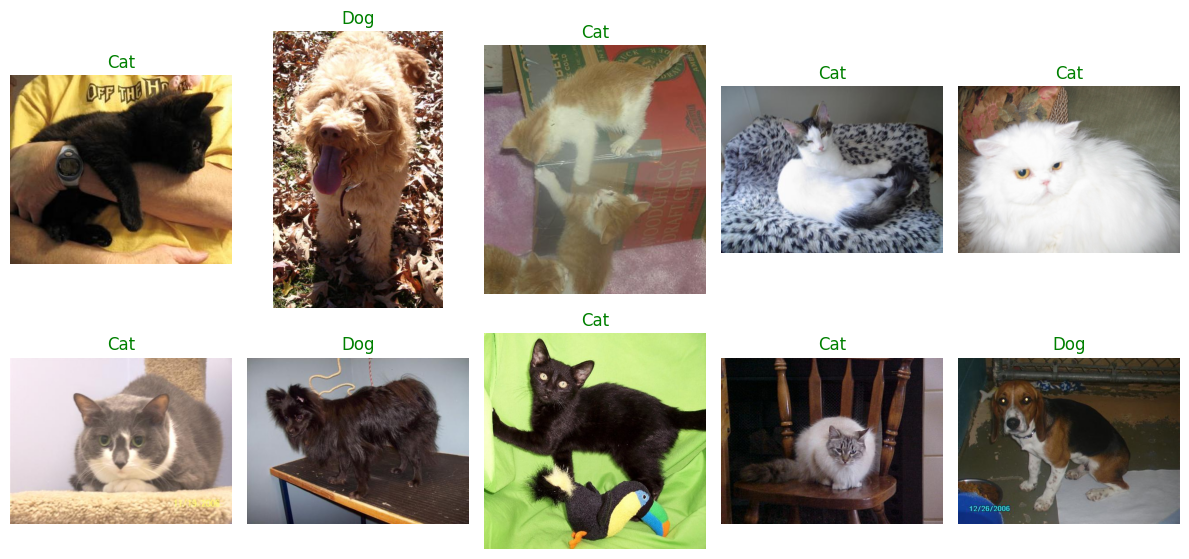

In [8]:
display_image_grid(test_images_filepaths)

###Pytorch 데이터세트 클래스 정의

실제로 라벨은 이 함수가 생성하며 DeepFake 코드에서도 VideoFrameDataset에서 이미지 및 라벨을 생성하여야 함.

다만, 데이터세트를 분류하는 부분에서 언급한 것 처럼 metadata.json에서 읽어서 라벨을 할당할지, 아니면 별도의 함수로 폴더를 REAL/FAKE로 생성해서 처리할지 결정해서 처리해야함.

또한, Cats vs Dogs의 경우 데이터 중 20,000개는 학습에 나머지 4,935개는 검증에 사용했고 학습이나 검증에 대한 라벨을 알 수 있는 상황이기 때문에 검증데이터도 라벨을 할당해서 loss나 accuracy를 확인할 수 있지만 DeepFake의 경우 테스트 데이터에 대해서는 라벨정보가 없기 때문에 모델의 학습이 완료된 후 최종 예측 결과(prediction results)만 얻을 수 있음.

In [9]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "Cat":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

###학습데이터와 검증데이터의 변환함수를 정의하기 위한 Albumentation 적용

아래 예제는 Cats vs Dogs 사례이며 학습하려는 이미지의 특성에 따라서 적정한 augmentation을 해야 함.

DeepFake의 경우 1위를 한 사람이 제시한 augmentation을 일단 적용하고 추가로 아이디어가 있다면 추가하여 성능을 비교하여 개선된다면 적용하는 것이 바람직함.
동영상에서 추출한 이미지에서 얼굴부분을 잘라내서 분류한다는 점을 감안하여 어떤 증강방식이 좋을지에 대한 아이디어가 필요함.

In [10]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=128, width=128),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataset = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=val_transform)

###Augmentation 결과를 표시하는 함수

In [11]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

###학습을 위한 Helper function 정의

In [12]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [13]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

###학습 파라메터 설정

In [14]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 4,
    "epochs": 10,
}

###학습과 검증을 위한 모든 함수와 객체 생성  

In [15]:
import torchvision

# torchivision v0.13 미만
#model = getattr(models, params["model"])(pretrained=False, num_classes=1,)

# torchivision v0.13+
weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 1)

model = model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 210MB/s]


In [16]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [28]:
print(len(train_dataset))
print(train_dataset[0])

for frames, labels in train_dataset:
    print(f"Frames shape: {frames.shape}") # [3, 128, 128]
    print(labels) # 1.0
    break

20000
(tensor([[[-1.9295, -1.6727, -1.6213,  ...,  1.1187,  1.2043,  1.2899],
         [-1.5699, -0.4568, -0.2684,  ...,  1.1015,  0.9817,  1.1187],
         [-1.1075,  1.0502,  1.1358,  ...,  1.2557,  1.1187,  1.1529],
         ...,
         [ 0.6221,  0.6221,  0.6221,  ...,  1.6667,  1.9920,  2.1804],
         [ 0.7248,  0.7591,  0.7591,  ...,  1.7523,  1.8037,  1.9407],
         [ 0.4679,  0.5878,  0.6563,  ...,  1.8722,  1.5297,  1.3070]],

        [[-1.6856, -1.3880, -1.3529,  ...,  1.3081,  1.3431,  1.3782],
         [-1.3704, -0.1450,  0.0651,  ...,  1.3957,  1.2206,  1.3606],
         [-0.9153,  1.3957,  1.5357,  ...,  1.5532,  1.3957,  1.4482],
         ...,
         [ 1.0455,  1.0280,  1.0630,  ...,  1.2206,  1.5532,  1.8333],
         [ 1.2556,  1.2731,  1.2906,  ...,  1.4307,  1.4657,  1.5532],
         [ 1.0980,  1.2206,  1.2906,  ...,  1.7108,  1.2906,  1.0280]],

        [[-1.6476, -1.3164, -1.2467,  ...,  1.4200,  1.6291,  1.7860],
         [-1.2293,  0.0082,  0.2348,  

In [26]:
for frames, labels in train_loader:
    print(f"Frames shape: {frames.shape}") # torch.Size([batch_size, 3, 128, 128])
    print(f"Labels shape: {labels.shape}") # torch.Size([batch_size])
    break

Frames shape: torch.Size([64, 3, 128, 128])
Labels shape: torch.Size([64])


In [29]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
#        print(images.shape) # (64, 3, row, col)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
#        print(target.shape) # (64, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

In [30]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

###모델 학습하기  

In [ ]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.228 | Accuracy: 0.915:   8%|▊         | 25/313 [00:08<01:01,  4.70it/s]

###이미지에 대해서 해당 라벨과 그 추정 결과를 표시하기  

In [ ]:
class CatsVsDogsInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = CatsVsDogsInferenceDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [ ]:
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
        predicted_labels += ["Cat" if is_cat else "Dog" for is_cat in predictions]

In [ ]:
display_image_grid(test_images_filepaths, predicted_labels)